<a href="https://colab.research.google.com/github/Diwakar-Gupta/DataScience/blob/main/Fast_Style_Transfer_for_Arbitrary_Styles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fast Style Transfer for Arbitrary Styles

In [ ]:
import os

from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)
print("TF Hub Version: ", hub.__version__)
print("Devices: ", tf.config.list_physical_devices())

TF Version:  2.8.0
TF Hub Version:  0.12.0
Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [ ]:


def crop_center(image):
  """Return a croped squared image"""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1]-shape[2], 0) // 2
  offset_x = max(shape[2]-shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape
  )
  return image

def load_image(image_url, image_size=(256,256), preserve_aspect_ration=True):
  """Loading and preprocessing Images."""
  img_path = tf.keras.utils.get_file(origin=image_url)
  img = tf.io.read_file(img_path)
  img = tf.io.decode_image(img, channels=3, dtype=tf.float32)[tf.newaxis, ...]

  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img

def show_n(images, titles=('', )):
  for image in images:
    plt.imshow(image[0])
    plt.show()


Let's get some images to play with.

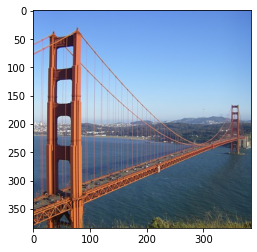

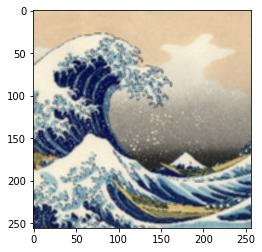

In [ ]:
# @title Load example image

content_image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Golden_Gate_Bridge_from_Battery_Spencer.jpg/640px-Golden_Gate_Bridge_from_Battery_Spencer.jpg' # @param {type:"string"}
style_image_url = 'https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg'  # @param {type:"string"}
output_image_size = 384  # @param {type:"integer"}

# The content image size can be any think.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the
# recommended image size for the style image (through, outer sizes work as
# well but will lead to different results).
style_img_size = (256, 256)

content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
show_n([content_image, style_image])

# Import TF Hub module

In [ ]:
hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

The signature of this hub module for image stylization is:

In [ ]:
outputs = hub_module(content_image, style_image)
sytlized_image = outputs[0]

# Demonstrate image stylization

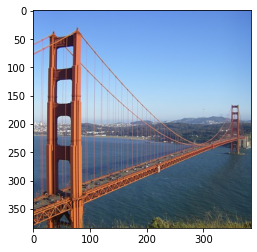

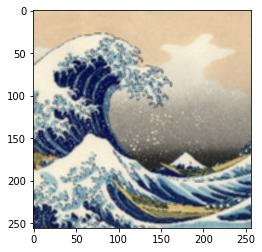

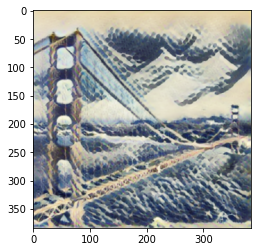

In [ ]:
# Visualize input images and the generated stylized image.

show_n([content_image, style_image, sytlized_image])

# Streamlit

In [ ]:
%%writefile app.py

import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image

import streamlit as st

from tempfile import NamedTemporaryFile

def crop_center(image):
  """Return a croped squared image"""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1]-shape[2], 0) // 2
  offset_x = max(shape[2]-shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape
  )
  return image

def load_image(img_path, image_size=(256,256), preserve_aspect_ration=True):
  """Loading and preprocessing Images."""
  # img_path = tf.keras.utils.get_file(origin=image_url)
  img = tf.io.read_file(img_path)
  img = tf.io.decode_image(img, channels=3, dtype=tf.float32)[tf.newaxis, ...]

  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img


# content_image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Golden_Gate_Bridge_from_Battery_Spencer.jpg/640px-Golden_Gate_Bridge_from_Battery_Spencer.jpg'
# style_image_url = 'https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg'
output_image_size = 384  

@st.cache
def get_hub():
    hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
    hub_module = hub.load(hub_handle)
    return hub_module

# The content image size can be any think.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the
# recommended image size for the style image (through, outer sizes work as
# well but will lead to different results).

# content_image = load_image(content_image_url, content_img_size)
# style_image = load_image(style_image_url, style_img_size)

# show_n([content_image, style_image])
getter1, getter2 = st.columns(2)

content_image = getter1.file_uploader('Content Image')
style_image = getter2.file_uploader('Style Image')
style_img_size = (256, 256)

if st.button('Process'):
    temp_file = NamedTemporaryFile(delete=False)
    temp_file.write(content_image.getvalue())
    content_image = load_image(temp_file.name)

    temp_file = NamedTemporaryFile(delete=False)
    temp_file.write(style_image.getvalue())
    style_image = load_image(temp_file.name)

    outputs = get_hub()(content_image, style_image)
    sytlized_image = outputs[0]

    st.image(sytlized_image.numpy())
else:
    st.write('Result Image')


Overwriting app.py


In [ ]:
!pip install streamlit

In [ ]:
!streamlit run app.py &> stm.out &

In [ ]:
!npx localtunnel --port 8501 &>npx.out &